### Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.  
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.   
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.  
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

In [1]:
#pip install fast_ml


### Импорт бибилиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    f1_score, recall_score, 
    precision_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix)
from sklearn.utils import shuffle

### Загрузка датасета

In [3]:
try:
    df = pd.read_csv('./datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


* В столбце Tenure не хватает около 1000 строк
* 3 классовых столбца (object) остальные - числовые
* Rownumber, CustomerId, Surname для модели использовать не будем, т.к. это уникальные значения, не являющиеся характиристиками заемщика.
* Можно перевести столбец IsActiveMember в булевый формат

In [5]:
df['IsActiveMember']=df['IsActiveMember'].astype('bool') #Изменим тип данных на булевый, чтобы меньше нагружать пк.
df['Exited']=df['Exited'].astype('bool')
df['HasCrCard']=df['HasCrCard'].astype('bool')

In [6]:
df[df['Tenure'].isna()].head(10) #Есть смысл посмотреть другие столбцы, где Tenure = NA

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,True,False,140469.38,True
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,False,True,90878.13,False
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,False,False,86424.57,False
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,False,False,164040.94,True
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,False,False,84509.57,False
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,False,False,26019.59,False
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,True,True,114675.75,False
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,False,True,85982.47,False
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,False,False,6534.18,False
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,True,False,27231.26,False


Какой-либо закономерностей я тут не увидел. Поэтому построим гистограмму столбца Tenure

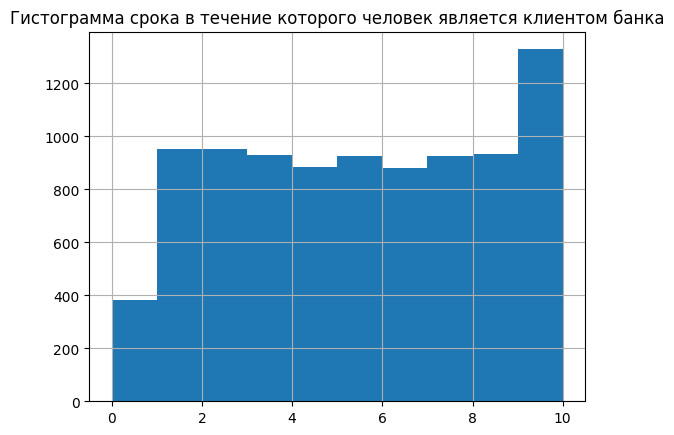

In [7]:
df['Tenure'].hist(bins = 10)
plt.title('Гистограмма срока в течение которого человек является клиентом банка')
plt.show()

Люди распределены довольно равномерно, чуть меньше людей только начали пользоваться банком и больше людей, которые уже 10 лет являются его клиентами.
Для начала заполним пропуски медианой, если этот способ не даст достаточной точности при построении модели, можно исопльзовать и другие варианты.

In [8]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [9]:
df.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.00000,10000.000000,10000.000000,10000,10000,10000.000000,10000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,2,2,NaN,2
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,True,True,NaN,False
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,7055,5151,NaN,7963
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.99790,76485.889288,1.530200,NaN,NaN,100090.239881,NaN
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.76001,62397.405202,0.581654,NaN,NaN,57510.492818,NaN
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.00000,0.000000,1.000000,NaN,NaN,11.580000,NaN
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.00000,0.000000,1.000000,NaN,NaN,51002.110000,NaN
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.00000,97198.540000,1.000000,NaN,NaN,100193.915000,NaN
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.00000,127644.240000,2.000000,NaN,NaN,149388.247500,NaN


* Первые 2 столбца нас не интересуют. Т.к. это идентификаторы, не содержащие полезной информации для модели.
* CreditScore потребует масштабирования как и другие числовые столбцы
* Явных аномалий на данной стадии не выявлено


In [10]:
df.duplicated().sum()

0

* Явных дубликатов нет

### Подготовка данных для моделей

In [11]:
df_ml = df.drop(['RowNumber','CustomerId','Surname'],axis = 1) #Удаляем прядковые столбцы, которые не нужны в модели
df_ml = pd.get_dummies(df_ml, drop_first=True) #Преобразуем категориальные данные методом Ohe
features = df_ml.drop(['Exited'],axis=1)
target = df_ml['Exited']
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(
    df_ml, target = 'Exited', train_size=0.8, valid_size=0.1, test_size=0.1)#Разделим данные на 3 группы в соотношении 80-10-10
print ('Размеры полученных выборок:')
print("Тренировочная: ", X_train.shape,y_train.shape)
print("Валидационная: ",X_valid.shape,y_valid.shape)
print("Тестовая: ",X_test.shape,y_test.shape)

Размеры полученных выборок:
Тренировочная:  (8000, 11) (8000,)
Валидационная:  (1000, 11) (1000,)
Тестовая:  (1000, 11) (1000,)


In [12]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1656,581,31,6.0,116891.72,1,True,False,107137.30,1,0,1
3855,708,32,3.0,151691.44,2,True,True,172810.51,1,0,1
6581,576,71,6.0,140273.47,1,True,True,193135.25,1,0,0
1801,452,30,7.0,112935.87,1,True,True,99017.34,0,0,1
7566,574,36,4.0,77967.50,1,True,False,167066.95,0,1,1


In [13]:
#Отберем числовые поля
numeric = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1656,-0.721784,-0.760731,0.373611,0.645264,-0.911383,True,False,0.134136,1,0,1
3855,0.592090,-0.665521,-0.714311,1.203296,0.806587,True,True,1.279495,1,0,1
6581,-0.773511,3.047685,0.373611,1.020203,-0.911383,True,True,1.633964,1,0,0
1801,-2.056349,-0.855941,0.736251,0.581830,-0.911383,True,True,-0.007479,0,0,1
7566,-0.794202,-0.284679,-0.351671,0.021093,-0.911383,True,False,1.179326,0,1,1


In [14]:
y_train.value_counts(normalize=True)

False    0.795375
True     0.204625
Name: Exited, dtype: float64

Наблюдается дисбаланс, необходимо увеличить количество положительных данных, используя технику upsampling
Доля положительных ответов составляет всего 20% значит модель чаще всего будет отвечать False, для тренировочной выборки есть смысл увеличить или уменьшить количество данных методами upsampling и downsampling

In [15]:
def upsample(features, target, repeat):
    features_zeros = features[target == False]
    features_ones = features[target == True]
    target_zeros = target[target == False]
    target_ones = target[target == True]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)


In [16]:
# Сразу сделаем функцию преобразования сособом downsampling
def downsampling(features,target):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    features_downsampled=pd.concat([features_null.sample(frac=0.4,random_state=1234)]+[features_one])
    target_downsampled=pd.concat([target_null.sample(frac=0.4,random_state=1234)]+[target_one])
    
    X_downsampled,y_downsampled=shuffle(features_downsampled,target_downsampled,random_state=1234)
    return X_downsampled,y_downsampled
X_downsampled, y_downsampled = downsampling(X_train, y_train)

In [17]:
y_upsampled.value_counts(normalize=True)

False    0.564396
True     0.435604
Name: Exited, dtype: float64

### Модель случайный лес
По заданию будем обучать модели на необработанных данных

In [18]:
best_result = 0
best_est = 0

for depth in range (1,13):
    for est in range (40,55):
        model_RF = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model_RF.fit(X_train, y_train)
        RF_prediction = model_RF.predict(X_valid)
        result = f1_score(y_valid, RF_prediction)
        if result > best_result:
            best_est = est
            best_result = result
            best_model = model_RF
            best_pred = RF_prediction
            best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"est =", best_est, "depth =", best_depth)
print ('Модель "Случайный лес: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred)))
print("Полнота" , recall_score(y_valid, best_pred))
print("Точность", precision_score(y_valid, best_pred))
print("F1-мера", f1_score(y_valid, best_pred))
print ("Мера Roc Auc", roc_auc_score(y_valid,best_pred))

Accuracy наилучшей модели на валидационной выборке: 0.5696594427244582 est = 40 depth = 11
Модель "Случайный лес: Метрики качества:


,0,1
0,769,26
1,113,92


Полнота 0.44878048780487806
Точность 0.7796610169491526
F1-мера 0.5696594427244582
Мера Roc Auc 0.7080380426445774


Апсемплинг позволил улучшить качество модели, посмотрим на остальные модели
Мы сразу уложились в таргет, F1 > 60%

### Модель "Логическая регрессия"

In [19]:
model_LR = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, class_weight='balanced') 
model_LR.fit(X_train, y_train)
LR_prediction = model_LR.predict(X_valid)
print ('Модель "Логическая регрессия: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, LR_prediction)))
print("Полнота" , recall_score(y_valid, LR_prediction))
print("Точность", precision_score(y_valid, LR_prediction))
print("F1-мера", f1_score(y_valid, LR_prediction))
print ("Мера Roc Auc", roc_auc_score(y_valid,LR_prediction))

Модель "Логическая регрессия: Метрики качества:


,0,1
0,588,207
1,67,138


Полнота 0.6731707317073171
Точность 0.4
F1-мера 0.5018181818181818
Мера Roc Auc 0.7063966866083756


Очень слабый результат. Линейная модель дала бы лучше результат, чем регрессия


### Модель "Дерево решений"

In [20]:
best_result = 0
best_depth = 0
for depth in range (1,6):
    model_DR = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_DR.fit(X_train, y_train)
    DF_prediction = model_DR.predict(X_valid)
    result = f1_score(y_valid, DF_prediction)
    if result > best_result:
        best_depth = depth
        best_result = result
        best_model_DR = model_DR
        best_pred_DR = DF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"max_depth =", best_est)
print ('Модель "Дерево решений: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred_DR)))
print("Полнота" , recall_score(y_valid, best_pred_DR))
print("Точность", precision_score(y_valid, best_pred_DR))
print("F1-мера", f1_score(y_valid, best_pred_DR))
print ("Мера Roc Auc", roc_auc_score(y_valid,best_pred))

Accuracy наилучшей модели на валидационной выборке: 0.5386064030131826 max_depth = 40
Модель "Дерево решений: Метрики качества:


,0,1
0,612,183
1,62,143


Полнота 0.697560975609756
Точность 0.4386503067484663
F1-мера 0.5386064030131826
Мера Roc Auc 0.7080380426445774


Тоже низкий результат. Очень часто дает негативные предсказания, значение True.  
По итогам этапа валидации оставляем модель случайного леса.
Проверим его не тестовой выборке

Выводы по итогам этапа валидации:
* Лучший f1score мы получили в модели Дерево решений -0,58
* Второе место - Логическая регрессия 0,45
* Третье место - Логическая регрессия. 
* Также в регрессии мы применили способ сбалансированных классов, что позволило улучшить результат.


### Теперь обучим модель на данных с учетом способа upsampling

In [21]:
best_result = 0
best_depth = 0
for depth in range (3,11):
    model_DR = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_DR.fit(X_upsampled, y_upsampled)
    DF_prediction = model_DR.predict(X_valid)
    result = f1_score(y_valid, DF_prediction)
    if result > best_result:
        best_depth = depth
        best_result = result
        best_model_DR_up = model_DR
        best_pred_DR = DF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"max_depth =", best_depth)
print ('Модель "Дерево решений: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred_DR)))
print("Полнота" , recall_score(y_valid, best_pred_DR))
print("Точность", precision_score(y_valid, best_pred_DR))
print("F1-мера", f1_score(y_valid, best_pred_DR))
print("roc_auc_score", roc_auc_score(y_valid, best_pred_DR))

Accuracy наилучшей модели на валидационной выборке: 0.5522682445759369 max_depth = 7
Модель "Дерево решений: Метрики качества:


,0,1
0,633,162
1,65,140


Полнота 0.6829268292682927
Точность 0.46357615894039733
F1-мера 0.5522682445759369
roc_auc_score 0.7395766221813163


Отличный результат: нам удалось повысить полноту, т.е. мы нашли почти 70% верных данных. При этом попали в таргет по F1

In [22]:
best_result = 0
best_est = 0

for depth in range (1,13):
    for est in range (40,55):
        model_RF = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model_RF.fit(X_upsampled, y_upsampled)
        RF_prediction = model_RF.predict(X_valid)
        result = f1_score(y_valid, RF_prediction)
        if result > best_result:
            best_est = est
            best_result = result
            best_model = model_RF
            best_pred = RF_prediction
            best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"est =", best_est, "depth =", best_depth)
print ('Модель "Случайный лес: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred)))
print("Полнота" , recall_score(y_valid, best_pred))
print("Точность", precision_score(y_valid, best_pred))
print("F1-мера", f1_score(y_valid, best_pred))
print ("Мера Roc Auc", roc_auc_score(y_valid,best_pred))

Accuracy наилучшей модели на валидационной выборке: 0.6019417475728155 est = 42 depth = 9
Модель "Случайный лес: Метрики качества:


,0,1
0,712,83
1,81,124


Полнота 0.6048780487804878
Точность 0.5990338164251208
F1-мера 0.6019417475728155
Мера Roc Auc 0.7502377665286087


### Обучение с использованием способа downsampling

In [23]:
best_result = 0
best_depth = 0
for depth in range (1,6):
    model_DR = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_DR.fit(X_downsampled, y_downsampled)
    DF_prediction = model_DR.predict(X_valid)
    result = f1_score(y_valid, DF_prediction)
    if result > best_result:
        best_depth = depth
        best_result = result
        best_model_DR = model_DR
        best_pred_DR = DF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"max_depth =", best_est)
print ('Модель "Дерево решений: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred_DR)))
print("Полнота" , recall_score(y_valid, best_pred_DR))
print("Точность", precision_score(y_valid, best_pred_DR))
print("F1-мера", f1_score(y_valid, best_pred_DR))
print ("roc_auc_score", roc_auc_score(y_valid,best_pred_DR))

Accuracy наилучшей модели на валидационной выборке: 0.5689277899343546 max_depth = 42
Модель "Дерево решений: Метрики качества:


,0,1
0,673,122
1,75,130


Полнота 0.6341463414634146
Точность 0.5158730158730159
F1-мера 0.5689277899343546
roc_auc_score 0.7403436109832797


Метод downsampling отработал хуже, поэтому остановимся на методе upsampling

In [24]:
best_pred_final = best_model.predict(X_test)
print ('Модель "Случайный лес: Метрики качества на тестовой выборке:')
display(pd.DataFrame(confusion_matrix(y_test, best_pred_final)))
print("Полнота" , recall_score(y_test, best_pred_final))
print("Точность", precision_score(y_test, best_pred_final))
print("F1-мера", f1_score(y_test, best_pred_final))
print ("roc_auc_score", roc_auc_score(y_test,best_pred_final))

Модель "Случайный лес: Метрики качества на тестовой выборке:


,0,1
0,723,82
1,75,120


Полнота 0.6153846153846154
Точность 0.594059405940594
F1-мера 0.6045340050377833
roc_auc_score 0.7567606306736742


На тестовой выборке модель отработала хуже, но результат вполне удовлетворительный по точности и гораздо лучше константы

In [25]:
probabilities_test = model_RF.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

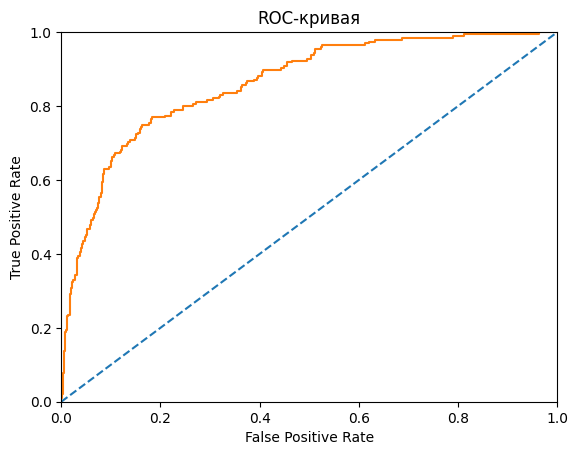

Auc_roc для константы на тестовой выборке 0.5
roc_auc_score для итоговой модели 0.7567606306736742


In [26]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
target_allzero_predicion_constant = pd.Series(0, index=y_test.index)
auc_roc_reg=roc_auc_score(y_test,target_allzero_predicion_constant)
print ("Auc_roc для константы на тестовой выборке",auc_roc_reg)
print ("roc_auc_score для итоговой модели", roc_auc_score(y_test,best_pred_final))


Отлично, мы видим, что наша модель работает гораздо лучше, а ее качественные показатели попали в таргет.

### Выводы

* В полученном датасете в одном из полей отсутствовали значения. Изучив список было принятно решение заполнить пропуски медианным значением.
* На этапе валидации была выбрана модель "Случайный лес", т.к. ее показатели были значительно выше других моделей. F1 score составил 63.4%
* В ходе работы над моделью выяснилось, что целевой столбец содержит только 20% положительных ответов, в результате чего был использован метод upsample
* При тестировании на тестовой выборке модель также отлично справилась, f1 score получилось 60,2%